using device: cuda:1


frame loading (JPEG): 100%|██████████| 97/97 [00:01<00:00, 52.96it/s]


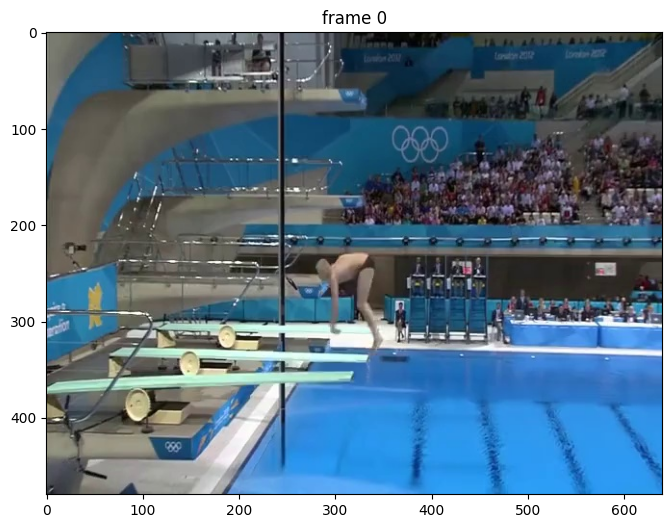

In [1]:
using_colab = False
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda:1")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


    


from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)



##########################################################################################################################################################################################################



#Function
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

##########################################################################################################################################################################


# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/media/cv/SSD/FRAMESCUTTRAIN/Bb0ZiYVNtDs_00030"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))    

inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)
    

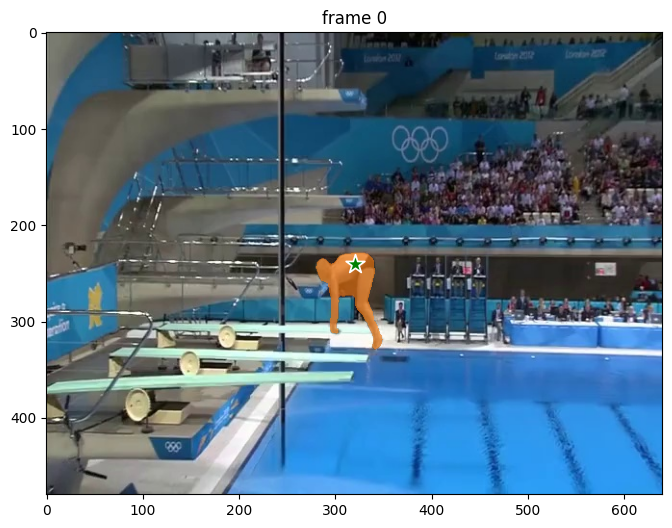

In [4]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[320,240]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

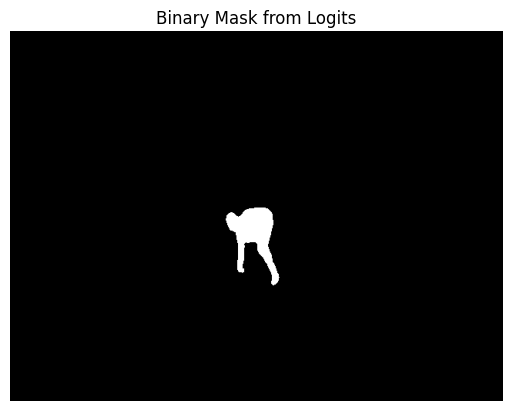

propagate in video: 100%|██████████| 97/97 [00:27<00:00,  3.46it/s]
/tmp/ipykernel_329454/1236989108.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  output_masks = torch.Tensor(output_masks)


torch.Size([97, 1, 1, 480, 640])
torch.Size([97, 1, 1, 480, 640])
torch.Size([97, 1, 480, 640])
torch.Size([97, 1, 480, 640])


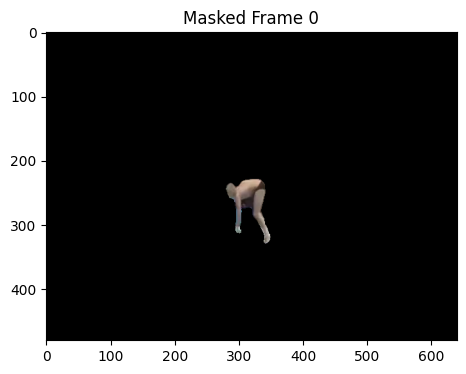

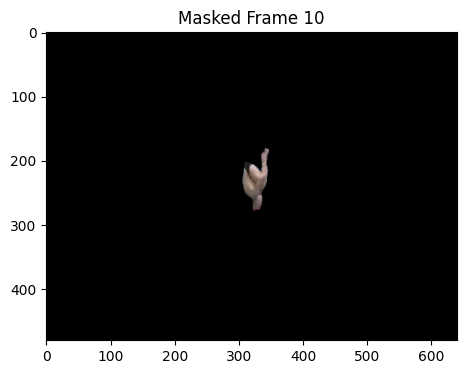

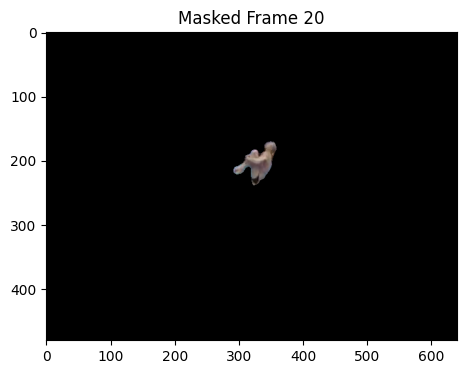

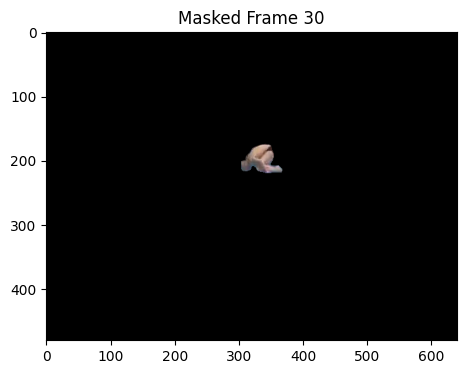

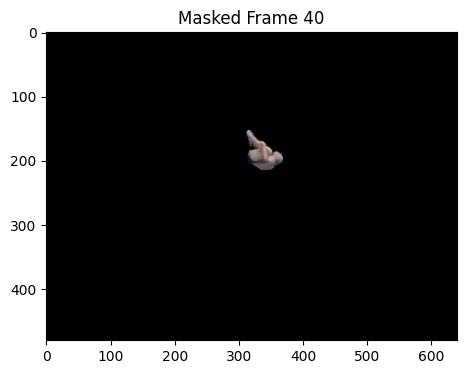

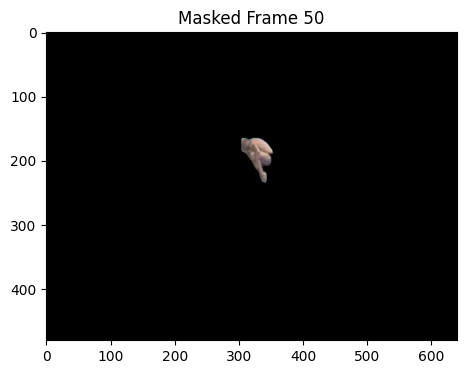

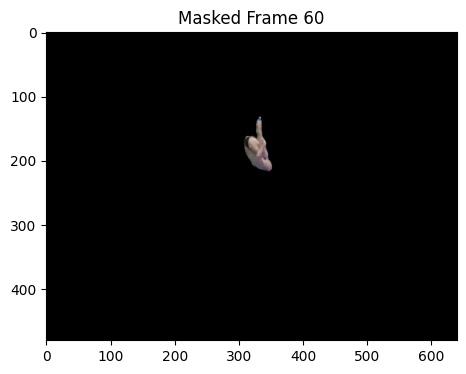

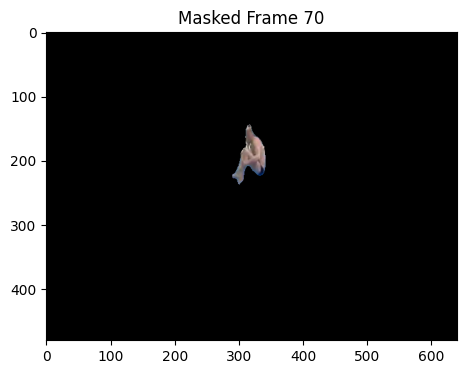

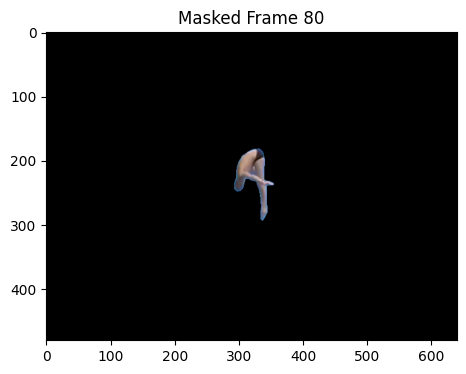

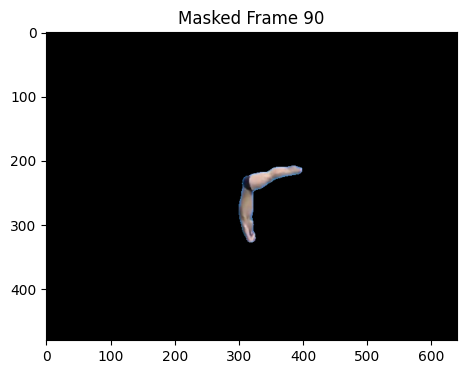

In [5]:
# Assuming `logits` is your logits tensor from the model
logits = out_mask_logits

# Convert logits to binary mask based on threshold (logits > 0)
binary_mask = (logits[0][0] > 0).float()  # Convert logits to binary mask

# Convert the binary mask tensor to NumPy array
binary_mask_np = binary_mask.cpu().detach().numpy()
# print(binary_mask)
# print(binary_mask_np)
# Show the binary mask using matplotlib
plt.imshow(binary_mask_np, cmap="gray", vmin=0, vmax=1)
plt.title("Binary Mask from Logits")
plt.axis('off')
plt.show()

######


# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
output_masks = []
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: ((out_mask_logits[i] > 0.0).float()*255).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    output_masks.append(out_mask_logits.cpu().numpy())
    # logits = out_mask_logits[i].shape

output_masks = torch.Tensor(output_masks)
print(output_masks.shape)
# render the segmentation results every few frames
# vis_frame_stride = 10
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(6, 4))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

#shape
num_frames = output_masks.size(0)
output_masks = output_masks.view(num_frames, 1, 1, 480, 640)
# output_masks=output_masks.view(56, 1, 1, 480, 640)
print(output_masks.shape)

#resize
# Remove unnecessary dimensions of size 1
output_masks = output_masks.squeeze(dim=2)  # Remove the extra second '1' dimension
print(output_masks.shape)
# print(output_masks)
binary_output_masks=(output_masks>0).float()
print(binary_output_masks.shape)


# Assuming `output_masks` is your logits tensor from the model and `frame_names` contains the list of all frame filenames.
# Assuming `video_dir` is the directory where the frames are stored.

# Function to apply binary mask to a single frame
def apply_mask_to_frame(logits, frame_path):
    # Convert logits to binary mask (threshold: logits > 0)
    binary_mask = (logits > 0).float()
    
    # Convert the binary mask tensor to NumPy array
    binary_mask_np = binary_mask.cpu().detach().numpy()

    # Load the original frame (make sure the frame is the same size or resize it)
    frame = cv2.imread(frame_path)  # Load original frame

    # Resize binary mask to match the original frame size (if needed)
    binary_mask_resized = cv2.resize(binary_mask_np, (frame.shape[1], frame.shape[0]))

    # Convert frame to float for multiplication
    frame_float = frame.astype(np.float32)

    # Multiply binary mask with the original frame
    masked_frame = frame_float * np.expand_dims(binary_mask_resized, axis=-1)  # Expand dims for RGB channels

    # Convert masked frame to uint8 for displaying
    masked_frame_uint8 = np.clip(masked_frame, 0, 255).astype(np.uint8)

    return masked_frame_uint8

# Function to process all frames
def process_all_frames(output_masks, frame_names, video_dir, vis_frame_stride):
    for frame_idx in range(0, len(frame_names), vis_frame_stride):
        frame_path = os.path.join(video_dir, frame_names[frame_idx])

        # Extract the logits for the current frame
        logits = output_masks[frame_idx][0]  # Assuming [192, 1, 480, 640]
        
        # Apply the mask to the frame
        masked_frame = apply_mask_to_frame(logits, frame_path)
        
        # Show the masked frame using matplotlib
        plt.figure(figsize=(6,4))
        plt.imshow(cv2.cvtColor(masked_frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Masked Frame {frame_idx}")
        # plt.axis('off')
        plt.show()

# Assuming `output_masks` is of shape [192, 1, 480, 640] and `frame_names` contains the filenames of the frames.
vis_frame_stride = 10  # Change stride to control how often frames are shown
process_all_frames(output_masks, frame_names, video_dir, vis_frame_stride)


In [7]:
# Function to apply binary mask to a single frame and return the masked frame
def apply_mask_to_frame(logits, frame_path):
    # Convert logits to binary mask (threshold: logits > 0)
    binary_mask = (logits > 0).float()

    # Convert the binary mask tensor to NumPy array
    binary_mask_np = binary_mask.cpu().detach().numpy()

    # Load the original frame
    frame = cv2.imread(frame_path)

    # Check if the frame was loaded successfully
    if frame is None:
        raise ValueError(f"Could not load frame from {frame_path}")

    # Resize binary mask to match the original frame size
    binary_mask_resized = cv2.resize(binary_mask_np, (frame.shape[1], frame.shape[0]))

    # Multiply the binary mask with the original frame
    frame_float = frame.astype(np.float32)
    masked_frame = frame_float * np.expand_dims(binary_mask_resized, axis=-1)  # Expand dims for RGB

    # Convert the masked frame to uint8 for saving
    masked_frame_uint8 = np.clip(masked_frame, 0, 255).astype(np.uint8)

    return masked_frame_uint8

# Function to process frames, apply masks, and save them
def process_and_save_frames(output_masks, frame_names, video_dir, vis_frame_stride, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Process and save frames
    for frame_idx in range(0, len(frame_names), vis_frame_stride):
        frame_path = os.path.join(video_dir, frame_names[frame_idx])

        # Extract the logits for the current frame
        logits = output_masks[frame_idx][0]

        # Apply the mask and get the masked frame
        masked_frame = apply_mask_to_frame(logits, frame_path)

        # Save the masked frame to the output directory
        output_frame_path = os.path.join(output_dir, f"{frame_idx:04d}.jpg")
        cv2.imwrite(output_frame_path, masked_frame)

# Function to convert saved frames into a video
def frames_to_video(output_dir, video_output_path, fps=30):
    # Get all saved frames in the directory
    frame_names = [f for f in os.listdir(output_dir) if f.endswith((".jpg", ".jpeg"))]
    frame_names.sort(key=lambda f: int(f.split('_')[-1].split('.')[0]))  # Sort by frame index

    if not frame_names:
        raise ValueError("No frames found in the directory to create the video.")

    # Read the first frame to get the frame dimensions
    first_frame = cv2.imread(os.path.join(output_dir, frame_names[0]))
    height, width, _ = first_frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use mp4v codec for mp4 format
    video_writer = cv2.VideoWriter(video_output_path, fourcc, fps, (width, height))

    # Write each frame to the video
    for frame_name in frame_names:
        frame_path = os.path.join(output_dir, frame_name)
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Could not read frame {frame_name}")
        else:
            video_writer.write(frame)

    # Release the VideoWriter and finalize the video
    video_writer.release()
    print(f"Video saved successfully to {video_output_path}")

# Parameters and paths
vis_frame_stride = 1  # Frame processing stride
# output_dir = "/media/cv/SSD/segment_frames/3"  # Directory to save masked frames
# video_dir = "/media/cv/SSD/segmented_videos/1/_8Vy3dlHg2w_00000"  # Directory where original frames are stored
# video_output_path = "/media/cv/SSD/segmented_videos/3.mp4"  # Path to save video


# Define the input video frames directory
# video_dir = "/media/cv/SSD/frames/_8Vy3dlHg2w_00000"  # Directory where the frames are stored

# Extract the last part of the video_dir for naming output directories
base_name = os.path.basename(video_dir)
# Define output paths using the base name
output_dir = os.path.join("/media/cv/SSD/train_frame(seg)", f"{base_name}")  # Directory to save masked frames
video_output_path = os.path.join("/media/cv/SSD/train_videos(seg)", f"{base_name}.mp4")


# Process and save frames with masks
process_and_save_frames(output_masks, frame_names, video_dir, vis_frame_stride, output_dir)

# Convert the saved frames into a video
frames_to_video(output_dir, video_output_path, fps=30)

# Check if the video was saved correctly
if os.path.exists(video_output_path):
    print(f"Video saved successfully at {video_output_path}")
else:
    print(f"Error: Video was not saved at {video_output_path}")


Video saved successfully to /media/cv/SSD/train_videos(seg)/Bb0ZiYVNtDs_00030.mp4
Video saved successfully at /media/cv/SSD/train_videos(seg)/Bb0ZiYVNtDs_00030.mp4
